In [2]:
import os
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import rasterio as rio
import math

## Functions for calculating vegetation indices from spectral bands
[Source of formulas](https://www.sentinel-hub.com/develop/documentation/eo_products/Sentinel2EOproducts)

In [2]:
### Normalized Difference Vegetation Index  (NDVI)
def ndvi(B08, B04):
    index = (B08 - B04) / (B08 + B04)
    return index

# Green Normalized Difference Vegetation Index   (GNDVI)
def gndvi(B08, B03):
    index = (B08 - B03) / (B08 + B03)
    return index

# Modified Chlorophyll Absorption in Reflectance Index (MCARI)
# General formula: ((700nm - 670nm) - 0.2 * (700nm - 550nm)) * (700nm /670nm)
def mcari(B05, B04, B03):
    index = ((B05 - B04) - 0.2 * (B05 - B03)) * (B05 / B04)
    return index

# Chlorophyll Red-Edge
# General formula: ([760:800]/[690:720])^(-1)
def red_edge(B07, B05):
    #index = math.pow((B07 / B05), (-1.0))
    index = (B07 / B05)**-1
    return index

# NDRE (Normalized difference red edge index) = NIR - RE/NIR + RE
def nrde(B8A, B05):
    index = (B8A - B05)/(B8A + B05)
    return index

# Normalized Difference 819/1600 NDII (NDII)
# General formula: (819nm-1600nm)/(819nm+1600nm)
def ndii(B8A, B11):
    index = (B8A - B11) / (B8A + B11)
    return index

# MSI - Simple Ratio 1600/820 Moisture Stress Index (MSI)
def msi(B11, B8A):
    index = B11 / B8A
    return index

In [3]:
indices = [ndvi, gndvi, mcari, red_edge, nrde, ndii, msi]

In [ ]:
## Calculate veg indices
# ndvi_arr = ndvi(b8.read(1), b4.read(1))
# gndvi_arr = gndvi(b8.read(1), b3.read(1))
# #mcari_arr = mcari(b5.read(1), b4.read(1), b3.read(1)) 
# re_arr = red_edge(b7.read(1), b5.read(1))
# nrde_arr = nrde(b8a.read(1), b5.read(1))
# ndii_arr = ndii(b8a.read(1), b11.read(1))
# msi_arr = msi(b11.read(1), b8a.read(1))

## Image processing house keeping

In [4]:
# Open a band with Rasterio and get metadata 
img_dir = "/Users/AuerPower/Metis/git/crop-classification/data/imagery/tile1/S2A_MSIL1C_20170620T082011_N0205_R121_T34JEP_20170620T084200.SAFE/GRANULE/L1C_T34JEP_A010414_20170620T084200/IMG_DATA/"
b4 = rio.open(img_dir + "T34JEP_20170620T082011_B04.jp2")
img_meta = b4.profile
img_meta

In [6]:
# change metadata profile to write Gtiff format, for 2 bands and float values instead of int
img_meta['count'] = 2
img_meta['dtype'] = 'float64'
img_meta['driver'] = 'Gtiff'
img_meta

{'driver': 'Gtiff', 'dtype': 'float64', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 2, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 6900040.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}

## Loop through imagery tiles and calculate veg indices
- For each veg index calculate the mean and standard deviation across time and save as a multiband raster

In [7]:
#import earthpy.spatial as es
import re
import fnmatch
from osgeo import gdal

In [8]:
# Get filenames for all months
img_dir = '/Users/AuerPower/Metis/git/crop-classification/data/imagery/sentinel2/'
output_dir = '/Users/AuerPower/Metis/git/crop-classification/data/intermediate/seasonal_veg/'

paths = os.listdir(img_dir)
paths[1]

'T34JEP_20170312T082001_B8A.jp2'

In [9]:
# Get list of months in filenames
b8_paths = [img_dir + file for file in paths if fnmatch.fnmatch(file, '*B08.jp2')]
months = [os.path.basename(b8).split('_')[1] for b8 in b8_paths]

In [10]:
## NDVI
layers = []
for m in months:
    B08 = rio.open(img_dir + 'T34JEP_' + m + '_B08.jp2').read(1)
    B04 = rio.open(img_dir + 'T34JEP_' + m + '_B04.jp2').read(1)
    veg_index = ndvi(B08, B04)
    layers.append(veg_index)
    
raster_stack = np.dstack(layers)
std_raster = np.std(raster_stack, axis=2)
mean_raster = np.mean(raster_stack, axis=2)

with rio.open(output_dir + 'ndvi.tiff','w', **img_meta) as veg_indices:
    veg_indices.write(mean_raster,1)
    veg_indices.write(std_raster,2)

In [11]:
## GNDVI
layers = []
for m in months:
    B08 = rio.open(img_dir + 'T34JEP_' + m + '_B08.jp2').read(1)
    B03 = rio.open(img_dir + 'T34JEP_' + m + '_B03.jp2').read(1)
    veg_index = gndvi(B08, B03)
    layers.append(veg_index)

raster_stack = np.dstack(layers)
std_raster = np.std(raster_stack, axis=2)
mean_raster = np.mean(raster_stack, axis=2)

with rio.open(output_dir + 'gndvi.tiff','w', **img_meta) as veg_indices:
    veg_indices.write(mean_raster,1)
    veg_indices.write(std_raster,2)

In [12]:
## Red edge
layers = []
for m in months:
    B07 = rio.open(img_dir + 'T34JEP_' + m + '_B07.jp2').read(1)
    B05 = rio.open(img_dir + 'T34JEP_' + m + '_B05.jp2').read(1)
    veg_index = red_edge(B07, B05)
    layers.append(veg_index)

raster_stack = np.dstack(layers)
std_raster = np.std(raster_stack, axis=2)
mean_raster = np.mean(raster_stack, axis=2)

with rio.open(output_dir + 're.tiff','w', **img_meta) as veg_indices:
    veg_indices.write(mean_raster,1)
    veg_indices.write(std_raster,2)

In [13]:
## NRDE
layers = []
for m in months:
    B8A = rio.open(img_dir + 'T34JEP_' + m + '_B8A.jp2').read(1)
    B05 = rio.open(img_dir + 'T34JEP_' + m + '_B05.jp2').read(1)
    veg_index = nrde(B8A, B05)
    layers.append(veg_index)

raster_stack = np.dstack(layers)
std_raster = np.std(raster_stack, axis=2)
mean_raster = np.mean(raster_stack, axis=2)

with rio.open(output_dir + 'nrde.tiff','w', **img_meta) as veg_indices:
    veg_indices.write(mean_raster,1)
    veg_indices.write(std_raster,2)

In [14]:
## ndii
layers = []
for m in months:
    B8A = rio.open(img_dir + 'T34JEP_' + m + '_B8A.jp2').read(1)
    B11 = rio.open(img_dir + 'T34JEP_' + m + '_B11.jp2').read(1)
    veg_index = ndii(B8A, B11)
    layers.append(veg_index)

raster_stack = np.dstack(layers)
std_raster = np.std(raster_stack, axis=2)
mean_raster = np.mean(raster_stack, axis=2)

with rio.open(output_dir + 'ndii.tiff','w', **img_meta) as veg_indices:
    veg_indices.write(mean_raster,1)
    veg_indices.write(std_raster,2)

In [15]:
## msi
layers = []
for m in months:
    B8A = rio.open(img_dir + 'T34JEP_' + m + '_B8A.jp2').read(1)
    B11 = rio.open(img_dir + 'T34JEP_' + m + '_B11.jp2').read(1)
    veg_index = msi(B11, B8A)
    layers.append(veg_index)

raster_stack = np.dstack(layers)
std_raster = np.std(raster_stack, axis=2)
mean_raster = np.mean(raster_stack, axis=2)

with rio.open(output_dir + 'msi.tiff','w', **img_meta) as veg_indices:
    veg_indices.write(mean_raster,1)
    veg_indices.write(std_raster,2)

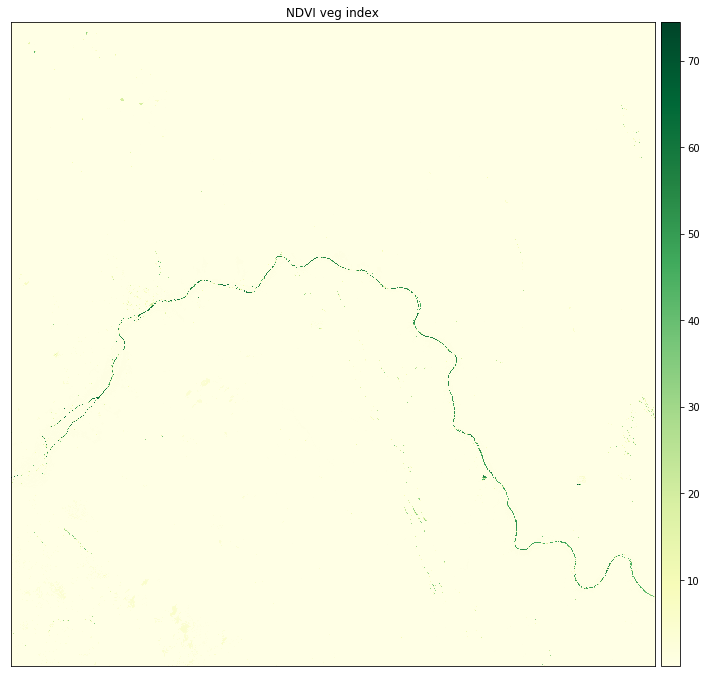

In [7]:
## Plot NDVI
import matplotlib.colors as colors
import earthpy.plot as ep

raster = rio.open('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/seasonal_veg/ndvi.tiff')
mean_ndvi = raster.read(1, masked=True)

ep.plot_bands(mean_ndvi,
              cmap='YlGn',
              title="NDVI veg index",
              scale=False)
plt.show()

#plt.imshow(mean_ndvi)
#plt.axis("off");

#### Here is a zoomed in image made with QGIS with multiple vegetation bands

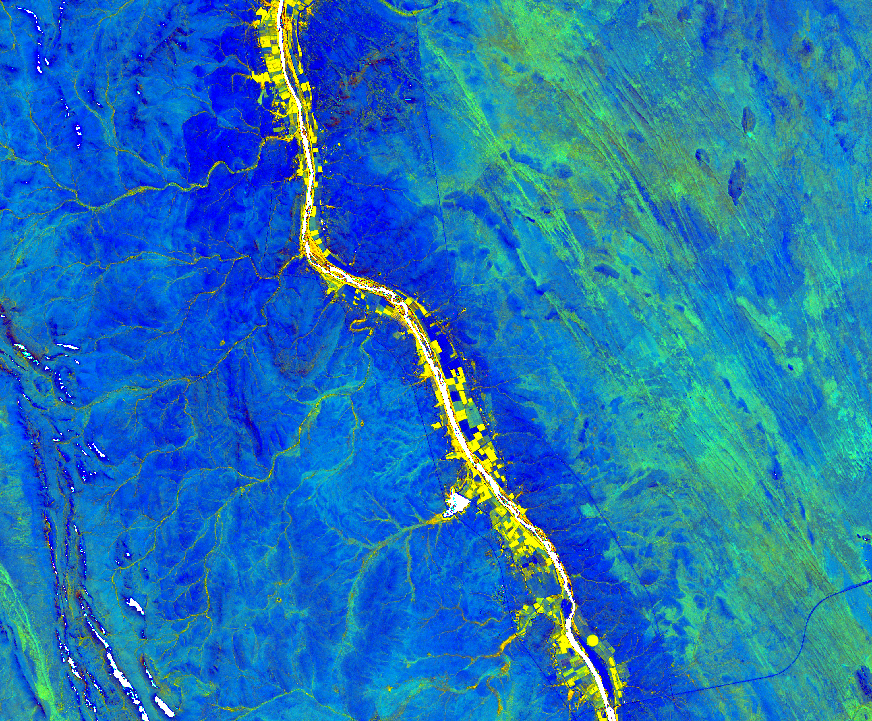